# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
#@title Install
#!pip install transformers
#!pip install git+https://github.com/openai/CLIP.git

In [2]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
#from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id=7) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = 'models/conceptual_weights.pt'


In [3]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [4]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [5]:
#@title GPU/CPU

is_gpu = True #@param {type:"boolean"}  

In [6]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(7) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [7]:
#@title Load model weights

prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(7) if is_gpu else "cpu"
model = model.to(device)

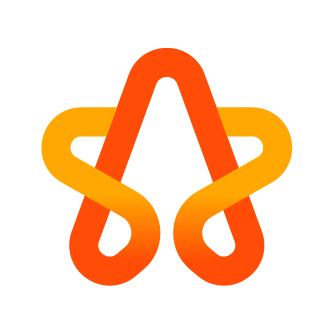

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]



icon in isometric 3d style on a white background vector.


In [9]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  

image = io.imread('/raid/asarkisov/MyProjects/Image-Captioning/data/dribble_logos/Slice 1.png')
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

print('\n')
print(generated_text_prefix)

In [11]:
import skimage.io as io
import PIL.Image
from os import listdir, rename
from os.path import isfile, join
from google_trans_new import google_translator
import json


def get_text_prefix(image_path: str) -> str:
  use_beam_search = False #@param {type:"boolean"}  

  image = io.imread(image_path)
  pil_image = PIL.Image.fromarray(image)
  #pil_img = Image(filename=UPLOADED_FILE)
  #display(pil_image)

  image = preprocess(pil_image).unsqueeze(0).to(device)
  with torch.no_grad():
      # if type(model) is ClipCaptionE2E:
      #     prefix_embed = model.forward_image(image)
      # else:
      prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
      prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
  if use_beam_search:
      generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
      return generated_text_prefix
  else:
      generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
      print(f'\n {generated_text_prefix}')
      return generated_text_prefix
    
  return ''


image_caption_dict = {}
translator = google_translator()

IMAGES_PATH = '/raid/asarkisov/MyProjects/Image-Captioning/data/dribble_logos'
file_paths = [join(IMAGES_PATH, f) for f in listdir(IMAGES_PATH) if isfile(join(IMAGES_PATH, f)) and (f.split(".")[1] == "png" or f.split(".")[1] == "jpg")]
with open('assets/dribble_captions_eng_rus.csv', 'w') as f:
  for idx, file_path in enumerate(file_paths):
    #try:
    generated_text_prefix = get_text_prefix(file_path)
    caption_eng = generated_text_prefix.replace(',', '').replace('.', '').strip()
    caption_rus = translator.translate(caption_eng, lang_tgt='ru').replace(',', '').replace('.', '').strip()
    file_name = file_path.split('/')[-1]
    image_caption_dict[file_name] = [caption_eng, caption_rus]
    
    print(f'\n{file_name} | {caption_eng} | {caption_rus} | {idx}/{len(file_paths) - 1}')
    f.write(f'\n{file_name}, {caption_eng}, {caption_rus}')
    #except:
    #  with open('assets/logo_captions.json', 'w') as fd:
    #    json.dump(image_caption_dict, fd)    

with open('assets/dribble_captions_eng_rus.json', 'w') as fd:
    json.dump(image_caption_dict, fd, ensure_ascii=False)    

100%|██████████| 1/1 [00:00<00:00,  9.32it/s]



 isolated pin with the name of the city.

sample_6.png | isolated pin with the name of the city | Изолированный булавка с названием города | 0/8


100%|██████████| 1/1 [00:00<00:00,  7.69it/s]



 icon in isometric 3d style on a white background vector.

sample_1.png | icon in isometric 3d style on a white background vector | Значок в изометрической 3d стиль на белом фоне вектор | 1/8


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]



 vector illustration of abstract icons based on the letter s.

sample_7.png | vector illustration of abstract icons based on the letter s | Векторная иллюстрация абстрактных значков на основе буквы S | 2/8


100%|██████████| 1/1 [00:00<00:00,  7.27it/s]



 a logo for a company that makes hand - painted watercolor paintings.

sample_8.png | a logo for a company that makes hand - painted watercolor paintings | Логотип для компании которая делает ручной росписью акварель | 3/8


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]



 isolated abstract icon of a person.

sample_2.png | isolated abstract icon of a person | Изолированные абстрактный значок человека | 4/8


100%|██████████| 1/1 [00:00<00:00, 16.82it/s]



 flag on the white background.

sample_9.png | flag on the white background | Флаг на белом фоне | 5/8


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


 the monkey is a symbol of good luck.



sample_4.png | the monkey is a symbol of good luck | Обезьяна - это символ удачи | 6/8


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


 vector illustration of abstract icons based on the letter.



sample_3.png | vector illustration of abstract icons based on the letter | Векторная иллюстрация абстрактных значков на основе письма | 7/8


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


 vector illustration of abstract icons based on the letter.

sample_5.png | vector illustration of abstract icons based on the letter | Векторная иллюстрация абстрактных значков на основе письма | 8/8


In [ ]:
import json

image_caption_dict = {}

with open('../assets/logo_captions_full.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    line = line.strip()
    image_name = line.split(' - ')[0]
    caption = 'logo of ' + line.split(' - ')[-1]
    image_caption_dict[image_name] = caption

with open('../assets/logo_captions_full_eng.json', 'w') as fd:
    json.dump(image_caption_dict, fd)

In [ ]:
import json

image_caption_dict = {}

with open('../assets/logo_captions_rus.txt', 'r') as f:
  lines = f.readlines()
  for line in lines:
    line = line.strip()
    image_name = line.split(' - ')[0]
    caption = line.split(' - ')[-1]
    image_caption_dict[image_name] = caption

with open('../assets/logo_captions_rus.json', 'w') as fd:
    json.dump(image_caption_dict, fd, ensure_ascii=False)